# Problem set 5
### Copied database from /blue/bsc4452/share/Class_Files

In [1]:
# Import only the modules needed from sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import Table, Column
from sqlalchemy import Integer, String
from sqlalchemy import sql, select, join, desc
from sqlalchemy import func

# Create a Engine object which is our handle into the database.
engine = create_engine('sqlite:///world.sqlite')

# Connect to the database
conn = engine.connect()

# Read the metadata from the existing database.
#  Since the database already exists and has tables defined, we can create Python objects based on these automatically.
DBInfo=MetaData(engine)

## Question 1 (5 points):
### What is the country with the latest year (most recent) of independence?

In [2]:
# Auto-create the country object basedon the metadata read into the DBInfo.
country=Table('country', DBInfo, autoload=True)

# SELECT Name, IndepYear FROM country ORDER BY IndepYear DESC LIMIT 1;
query=select([country.c.Name, country.c.IndepYear])\
             .order_by(desc(country.c.IndepYear))\
             .limit(1)

result = conn.execute(query)

# Print results
for row in result:
    print(row)

('Palau', 1994)


## Question 2 (5 points):
### There are several countries that have become independent since the country in your answer to question 1, add one to the database.

In [3]:
### Question 2 (5 points):

## Make sure country code is available
# query=select([country.c.Code, country.c.Name]).where(country.c.Code.like('SE%'))
# result = conn.execute(query)
# for row in result:
#    print(row)

## Check to see what options there are for filling in data
# print(country.insert())

## Add insert for Serbia
my_insert_serbia=country.insert().values(Code='SER', Name='Serbia', Continent='Europe', Region='Eastern Europe', IndepYear='2006', Population='6963764')
#print(my_insert_serbia)

result = conn.execute(my_insert_serbia)

## Check to make sure it was added
query=select([country.c.Code, country.c.Name, country.c.Continent, country.c.Region, country.c.IndepYear, country.c.Population]).where(country.c.Name.like('Se%'))

result = conn.execute(query)

for row in result:
    print(row)


('SEN', 'Senegal', 'Africa', 'Western Africa', 1960, 9481000)
('SYC', 'Seychelles', 'Africa', 'Eastern Africa', 1976, 77000)
('SER', 'Serbia', 'Europe', 'Eastern Europe', 2006, 6963764)


## Question 3 (5 points):
#### For the country added in question 2, find 2 cities to add to the cities table of the database.

In [4]:
# Auto-create the cities object basedon the metadata read into the DBInfo.
city=Table('city', DBInfo, autoload=True)

## Check to see what options there are for filling in data
#print(city.insert())

## Add insert for Belgrade, Serbia (largest population)
my_insert_belgrade=city.insert().values(Name='Belgrade', CountryCode='SER', Population='1659440')
#print(my_insert_belgrade)
result = conn.execute(my_insert_belgrade)

## Add insert for Crna Trava, Serbia (smallest population)
my_insert_crnatrva=city.insert().values(Name='Crna Trava', CountryCode='SER', Population='1663')
#print(my_insert_crnatrva)
result = conn.execute(my_insert_crnatrva)


## Check to make sure the inserts were added
query=select([city.c.Name, city.c.CountryCode, city.c.Population]).where(city.c.CountryCode.like('SER'))

result = conn.execute(query)

for row in result:
    print(row)


('Belgrade', 'SER', 1659440)
('Crna Trava', 'SER', 1663)


## Question 4 (5 points):
### Using the LifeExpectancy data in the country table on the y-axis, plot this data against some other value.

                  Continent  IndepYear  LifeExpectancy  Population       GNP
Name                                                                        
Aruba         North America        NaN            78.4      103000     828.0
Afghanistan            Asia     1919.0            45.9    22720000    5976.0
Angola               Africa     1975.0            38.3    12878000    6648.0
Anguilla      North America        NaN            76.1        8000      63.2
Albania              Europe     1912.0            71.6     3401200    3205.0
...                     ...        ...             ...         ...       ...
Yugoslavia           Europe     1918.0            72.4    10640000   17000.0
South Africa         Africa     1910.0            51.1    40377000  116729.0
Zambia               Africa     1964.0            37.2     9169000    3377.0
Zimbabwe             Africa     1980.0            37.8    11669000    5951.0
Serbia               Europe     2006.0             NaN     6963764       NaN

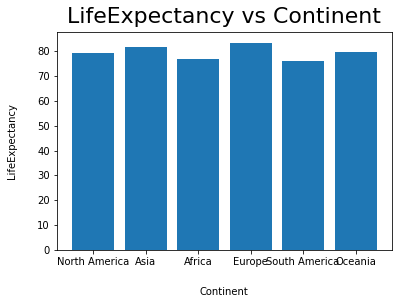

In [5]:
# Import what is needed 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Get data for dataframe
query=select([country.c.Name, country.c.Continent, country.c.IndepYear, country.c.LifeExpectancy, country.c.Population, country.c.GNP])

result = conn.execute(query)

## Make pandas dataframe
df=pd.read_sql(query, conn, index_col='Name')

print(df)

## Plot 
x = df['Continent']
y = df['LifeExpectancy']


plt.bar(x, y)
plt.xlabel("Continent", labelpad=20)
plt.ylabel("LifeExpectancy", labelpad=20)
plt.title("LifeExpectancy vs Continent", y=1.015, fontsize=22);

plt.show()



## Grad student extra credit (5 points, sorry undergrads, only question 4 counts as extra credit):
### Plot LifeExpectancy vs the ratio of the total population of all the cities in the country divided by the total population of the country. This is an approximation of the % urban population in the country.

             Code  Population  LifeExpectancy CountryCode     sum_1  \
Name                                                                  
Aruba         ABW      103000            78.4         ABW     29034   
Afghanistan   AFG    22720000            45.9         AFG   2332100   
Angola        AGO    12878000            38.3         AGO   2561600   
Anguilla      AIA        8000            76.1         AIA      1556   
Albania       ALB     3401200            71.6         ALB    270000   
...           ...         ...             ...         ...       ...   
Yemen         YEM    18112000            59.8         YEM   1743700   
Yugoslavia    YUG    10640000            72.4         YUG   2189507   
South Africa  ZAF    40377000            51.1         ZAF  15196370   
Zambia        ZMB     9169000            37.2         ZMB   2473500   
Zimbabwe      ZWE    11669000            37.8         ZWE   2730420   

              UrbanPopulation  
Name                           
Aruba       

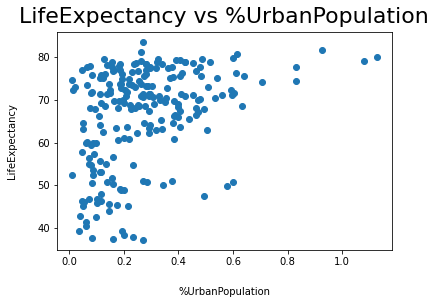

In [6]:
## New query for all the cities, country code, and pop
query=select([country.c.Code, country.c.Name, country.c.Population,country.c.LifeExpectancy, city.c.CountryCode, func.sum(city.c.Population)]).group_by(city.c.CountryCode).select_from(country.join(city, city.c.CountryCode == country.c.Code))

result = conn.execute(query)


## Make pandas dataframe
df=pd.read_sql(query, conn, index_col='Name')

## Make new column to get % urban population
UP = df["sum_1"] / df["Population"]
df["UrbanPopulation"] = UP
print(df)


## Plot 
x = df['UrbanPopulation']
y = df['LifeExpectancy']

plt.scatter(x, y)
plt.xlabel("%UrbanPopulation", labelpad=20)
plt.ylabel("LifeExpectancy", labelpad=20)
plt.title("LifeExpectancy vs %UrbanPopulation", y=1.015, fontsize=22);

plt.show()
